# Imports and Data Load

In [34]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression

from scipy.stats import randint

from scipy import stats

from collections import Counter

In [35]:
df = pd.read_csv('train.csv')

In [36]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [38]:
#check data types to see how to analyze/clean each column
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Outlier Handling

In [39]:
# Outlier detection 

def detect_outliers(df,n,features):
    #Takes a dataframe df of features returns indexes of rows with at least n outliers, using the tukey method for outlier detection
    
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        outlier_mod = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_mod) | (df[col] > Q3 + outlier_mod )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # use counter to identify indexes that appear at least n times, add them to multiple outlier list
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from numeric features
outliers = detect_outliers(df,2,["Age","SibSp","Parch","Fare"])

In [40]:
df.loc[outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [41]:
#Since there are so few outliers, and no way to identify whether the outliers are a data error, or a legitimate value, these rows are dropped
outliers
df.drop(outliers, axis = 0, inplace = True)
df.reset_index(inplace = True, drop = True)

# Numeric Feature Analysis

In [42]:
#check for NaN values
for col in df.columns:
    numnull = df[col].isnull().sum()
    print(col + ":" + str(numnull))

PassengerId:0
Survived:0
Pclass:0
Name:0
Sex:0
Age:170
SibSp:0
Parch:0
Ticket:0
Fare:0
Cabin:680
Embarked:2


In [43]:
df[["Survived","SibSp","Parch","Age","Fare"]].corr()

,Survived,SibSp,Parch,Age,Fare
Survived,1.000000,0.003330,0.092819,-0.076867,0.264613
SibSp,0.003330,1.000000,0.379281,-0.307129,0.110072
Parch,0.092819,0.379281,1.000000,-0.186457,0.183801
Age,-0.076867,-0.307129,-0.186457,1.000000,0.110219
Fare,0.264613,0.110072,0.183801,0.110219,1.000000


<AxesSubplot:>

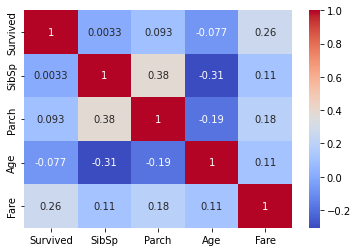

In [44]:
sns.heatmap(df[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot = True, cmap = "coolwarm")

## Siblings and Spouses

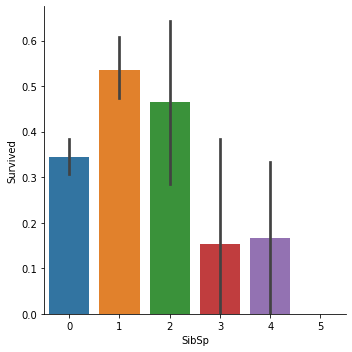

In [45]:
#We see people with fewer siblings appear to survive more often than people with many siblings, though we note there's a lot of variability for high sibling counts
sns.catplot(x="SibSp", y = "Survived", data = df, kind = 'bar')


## Parents and Children

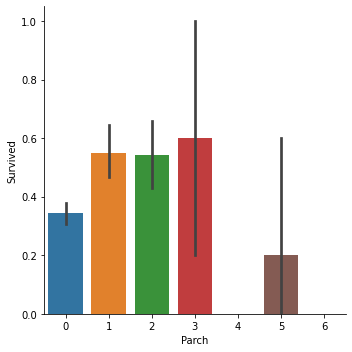

In [46]:
#We see people with fewer parents or children aboard are more likely to survive.  Worth noting that higher parch values probably represent adults, as a child can have at most 2 parents, so the low survival rate could be due to their age, rather than their parch
sns.catplot(x="Parch", y = "Survived", data = df, kind = 'bar')

## Age

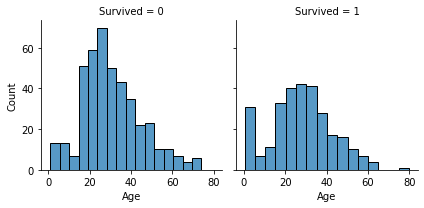

In [47]:
#At a glance, looks like younger people survive more, with 60+ people rarely living.  Distributions look close to normal, but are a little tailed
diff = sns.FacetGrid(df, col = 'Survived')
diff = diff.map(sns.histplot, "Age")

## Fare

Skew Score: 5.058014586919519


C:\Users\Brian\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare', ylabel='Density'>

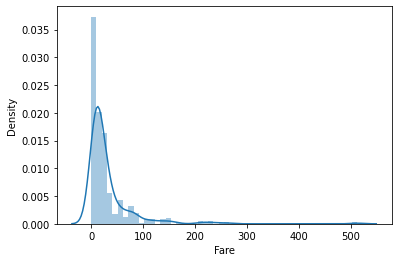

In [48]:
#Data is highly skewed, will need to be transformed
print("Skew Score: {}".format(df['Fare'].skew()))
sns.distplot(df['Fare'])


Skew Score: 0.4396810996226742


C:\Users\Brian\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare', ylabel='Density'>

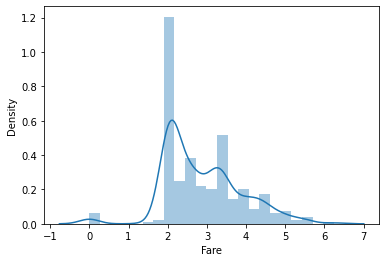

In [49]:
# Use log function to reduce skew
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
print("Skew Score: {}".format(df['Fare'].skew()))
sns.distplot(df['Fare'])

# Categorical Feature Analysis

In [50]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S


## Passenger Class

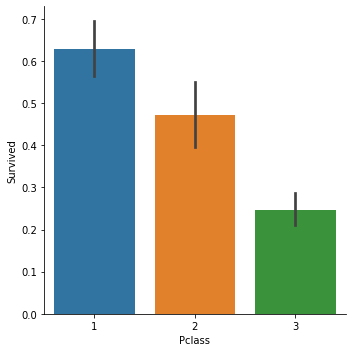

In [51]:
#First and second class ticket holders were much more likely to survive than third class
sns.catplot(x="Pclass", y="Survived", data = df, kind = 'bar')

## Sex

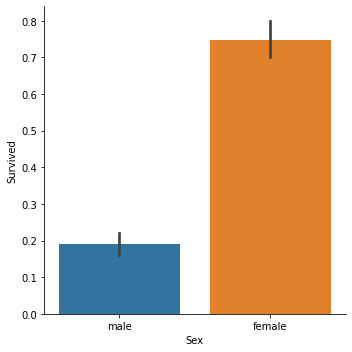

In [52]:
#Women survived Considerably more often compared to men
sns.catplot(x="Sex", y="Survived", data = df, kind = 'bar')

## Emabarked

In [53]:
df['Embarked'].isnull().sum()

2

In [54]:
#Embarked is missing only 2 value, I imputed those with the most common value of the column

df['Embarked'].value_counts()

S    634
C    168
Q     77
Name: Embarked, dtype: int64

In [55]:
df["Embarked"] = df["Embarked"].fillna("S")

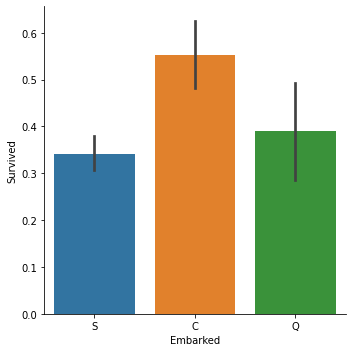

In [56]:
#Those embarking from Cherburg survived the most often, though its important to note high variability for Cherburg and Queenstown
sns.catplot(x='Embarked', y='Survived', data = df, kind = 'bar')

# Filling Null Values

In [57]:
#impute NaN age values, with the median age of passengers with the same number of siblings, parch, and ticket class, or overall median age where that's not possible
index_NaN_age = list(df["Age"][df["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = df['Age'].dropna().median()
    age_pred = df["Age"][((df['SibSp'] == df.iloc[i]["SibSp"]) & (df['Parch'] == df.iloc[i]["Parch"]) & (df['Pclass'] == df.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        df['Age'].iloc[i] = age_pred
    else :
        df['Age'].iloc[i] = age_med

C:\Users\Brian\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Brian\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Brian\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

C:\Users\Brian\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Brian\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Brian\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

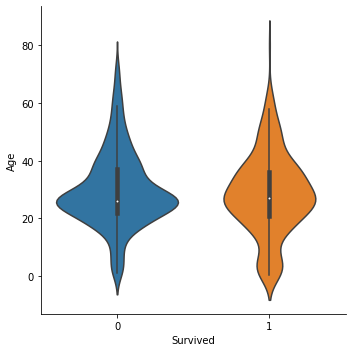

In [58]:
#The median age for surviving vs not surviving is similar, though we can see very young people survived more often than not, and very elderly people didn't survive more often than not
sns.catplot(x="Survived", y = "Age",data = df, kind="violin")

In [59]:
#impute NaN Fare values, with the median fare of passengers with the same number of siblings, parch, and ticket class, or overall median fare where that's not possible
index_NaN_age = list(df["Age"][df["Age"].isnull()].index)
index_NaN_fare = list(df["Fare"][df["Fare"].isnull()].index)

for i in index_NaN_fare :
    age_med = df['Fare'].dropna().median()
    age_pred = df["Fare"][((df['SibSp'] == df.iloc[i]["SibSp"]) & (df['Parch'] == df.iloc[i]["Parch"]) & (df['Pclass'] == df.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        df['Fare'].iloc[i] = age_pred
    else :
        df['Fare'].iloc[i] = age_med

# New Feature Engineering

In [60]:
#Add family feature, equal to number of siblings/spouses + number of parents/children
df['Family'] = df['Parch'] + df['SibSp']

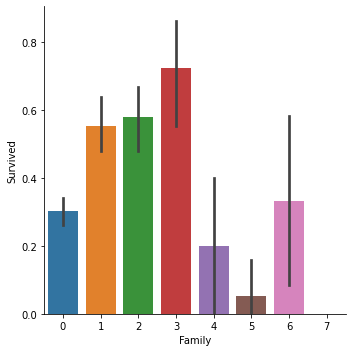

In [61]:
#Large families survived infrequently comperd to smaller families, though variability is high as there aren't many large family records
sns.catplot(x='Family', y = 'Survived', data = df, kind = 'bar')

In [62]:
#extract titles from names
title_list = []
for name in df['Name']:
    title = name.split(' ')[1]
    if title in ['Mr.', 'Miss.', 'Mrs.', 'Master.']:
        title_list.append(title)
    else:
        title_list.append('Other')
    
titles = pd.Series(title_list)
titles.value_counts()
df['Title'] = titles


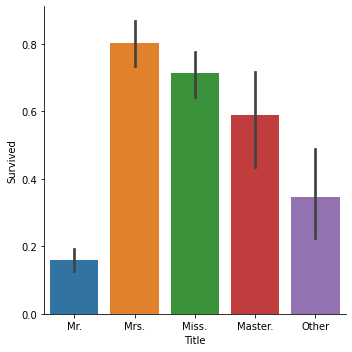

In [63]:
#Weomen survived more often then men, but if we take master as indicitive of status, high status people survived fairly often regardless of gender
sns.catplot(x='Title', y='Survived', data = df, kind = 'bar')

In [64]:
#Too many distinct cabin values, reduced by limniting them to their first letter, which gives us an idea of where they were on the ship
df['Cabin'].value_counts()

B96 B98    4
G6         4
F2         3
C22 C26    3
E101       3
          ..
C32        1
E34        1
C7         1
C54        1
C148       1
Name: Cabin, Length: 147, dtype: int64

In [65]:
cabin_list = []
for cabin in df['Cabin']:
    cabin_list.append(str(cabin)[0])


cabins = pd.Series(cabin_list)
df['Cabin_Label'] = cabins 
cabins.value_counts()


n    680
C     56
B     47
D     33
E     32
A     15
F     13
G      4
T      1
dtype: int64

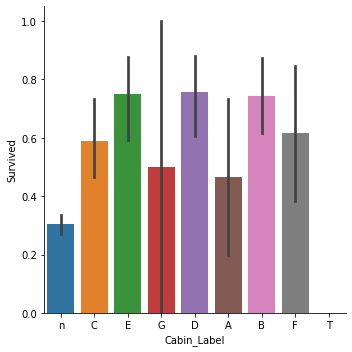

In [66]:
#Most cabins are fairly close, keeping the error bars in mind, but n in particular has a very low survival rate
sns.catplot(x="Cabin_Label", y='Survived', data=df, kind='bar')

# Modeling

In [67]:
#Drop Columns we don't want to use (because they are text based or have been replaced by a different column)
df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'SibSp', 'Parch'], axis = 1, inplace = True)
#Create dummy variables, to transform categories into 1s and 0s for the model
df = pd.get_dummies(df,columns=['Title', "Pclass","Sex", 'Embarked', 'Cabin_Label'])

In [68]:
df.head()

,Survived,Age,Fare,Family,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Other,Pclass_1,...,Embarked_S,Cabin_Label_A,Cabin_Label_B,Cabin_Label_C,Cabin_Label_D,Cabin_Label_E,Cabin_Label_F,Cabin_Label_G,Cabin_Label_T,Cabin_Label_n
0,0,22.0,1.981001,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,38.0,4.266662,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,26.0,2.070022,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,35.0,3.972177,1,0,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
4,0,35.0,2.085672,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [69]:
#Separate out target variable and predictor variables
y = df['Survived']
X= df.drop('Survived', axis=1)
X_scaled = pd.DataFrame(preprocessing.scale(X), columns = list(X.columns))

In [70]:
#Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.3, random_state=42)

In [71]:
#use random search to find good hyperparameters for randomforest classifier
param_dist = {"n_estimators": randint(1,100),
              "max_depth": randint(1, 9),
              "max_features": randint(1, 13),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tree = RandomForestClassifier()

tree_cv = RandomizedSearchCV(tree, param_dist, cv=5, n_iter=100)

tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 47}
Best score is 0.8489247311827957


In [72]:
rf= RandomForestClassifier(criterion='gini', max_depth= 6, max_features=7, min_samples_leaf= 2, n_estimators= 47)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.8301886792452831


In [73]:
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

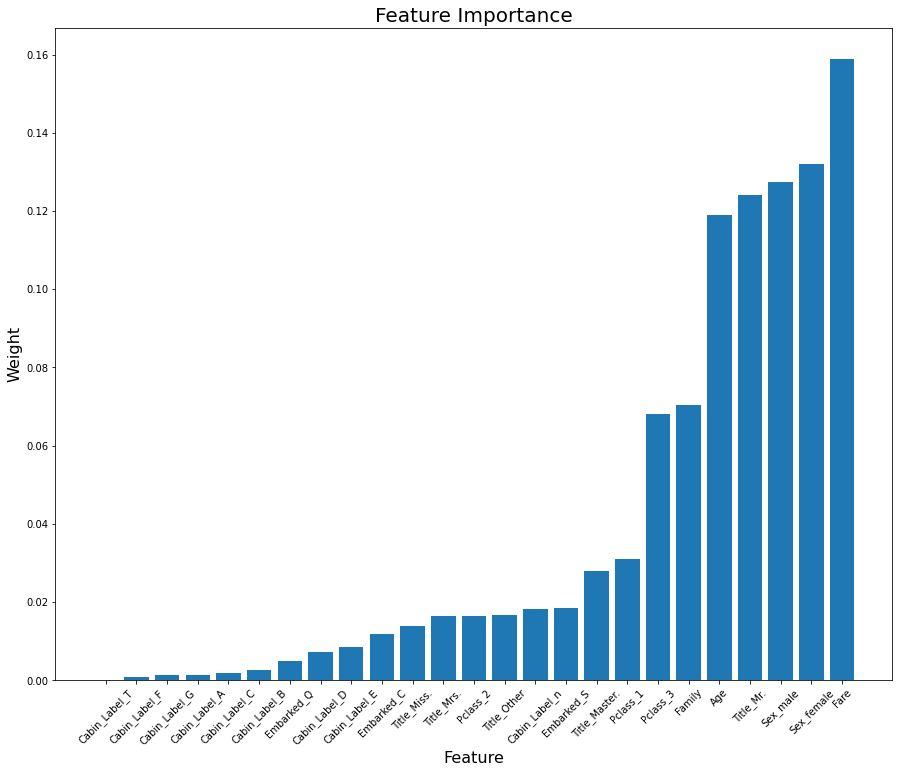

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.bar(list(importances_sorted.keys()), list(importances_sorted.values))
fig.set_size_inches([15, 12])
plt.xticks(rotation = 45)
ax.set_title("Feature Importance", fontsize = 20)
ax.set_xlabel('Feature', fontsize=16)
ax.set_ylabel('Weight', fontsize=16)
plt.show()

# Logistic Regression

In [75]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [76]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


In [77]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[142  17]
 [ 25  81]]


In [78]:
d = {'feature':X_test.columns,'coef':logreg.coef_[0]}

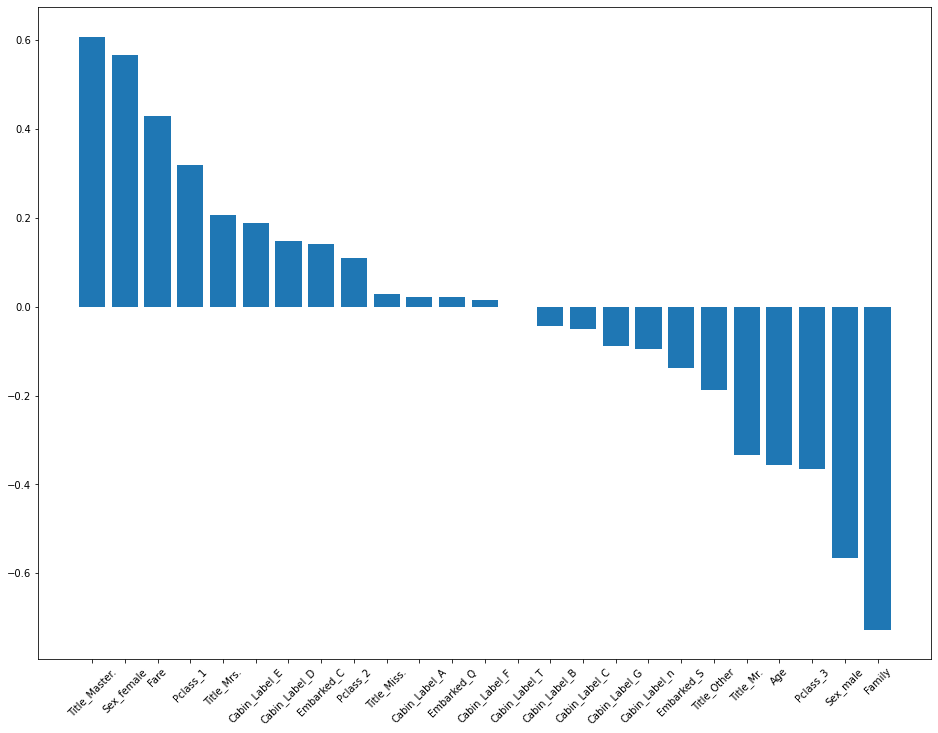

In [79]:
coef_df = pd.DataFrame(d).sort_values('coef', ascending = False)
plt.figure(figsize=(16, 12))
plt.bar(x = coef_df['feature'], height=coef_df['coef'])
plt.xticks(rotation = 45)
plt.show()